In [ ]:
from __future__ import division
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
d={}
with open('/content/drive/My Drive/TCS1/forms.txt') as f:
  for line in f:
    key=line.split(' ')[0]
    write=line.split(' ')[1]
    d[key]=write
from collections import Counter
top_7=[]
num_write= Counter(d.values())
#Collecting the most common 7 writers 
for key,value in num_write.most_common(7):
  top_7.append(key)
select_forms = {}
for k,v in d.items():
    if v in top_7:
        select_forms[k]=v
import pickle
#id_list.pkl contains the list of all file paths of every image present in sentences folder
with open('id_list.pkl','rb') as f:
  id_list=pickle.load(f)
temp=[]
target=[]
for filename in sorted(id_list):
  form=filename.split('/')[-2]
  for key in select_forms:
    if key==form:
      target.append(str(select_forms[form]))
      temp.append(filename)
images_file=np.asarray(temp)
target_array=np.asarray(target)

image_files contains the filepath of the images

target_array contains the writer ids of 7 people which we need to predict

In [ ]:
images_file.shape

(1333,)

In [ ]:
target_array.shape

(1333,)

In [ ]:
#encoding the target array 
encoder=LabelEncoder()
encoder.fit(target_array)
encoded_Y=encoder.transform(target_array)
#Splitting the dataset into training,testing and validation data
from sklearn.model_selection import train_test_split
train_files,rem_files,train_targets,rem_targets=train_test_split(images_file,encoded_Y,train_size=0.66,random_state=52,shuffle=True)
validation_files,test_files,validation_targets,test_targets=train_test_split(rem_files,rem_targets,train_size=0.5,random_state=22,shuffle=True)
from PIL import Image
from random import sample 
batch_size=16
num_classes=20
#generating random crops of the sentence image to generate the features from images.
def generate_data(samples,target_files,batch_size=batch_size,factor=0.1):
  l2=[]
  num_samples=len(samples)
  from sklearn.utils import shuffle
  while 1:
      for j in range(0,num_samples,batch_size):
        batch_samples=samples[j:j+batch_size]
        batch_targets=target_files[j:j+batch_size]
        images=[]
        targets=[]
        for i in range(len(batch_samples)):
          batch_sample=batch_samples[i]
          batch_target=batch_targets[i]
          im=Image.open(batch_sample)
          cur_width=im.size[0]
          cur_height=im.size[1]
          height_frac=113/cur_height
          new_width=int(cur_width*height_frac)
          size=new_width,113
          # Resize so height=113 while keeping aspect ratio
          im_resize=im.resize((size),Image.ANTIALIAS)
          now_width=im_resize.size[0]
          now_height=im_resize.size[1]
          # Generate crops of size 113x113 from this resized image and keep random 10% of crops
          avail_x_points=list(range(0,now_width-113))
          pick_num=int(len(avail_x_points)*factor)
          random_startx=sample(avail_x_points,pick_num)
          
          for start in random_startx:
            imcrop=im_resize.crop((start,0,start+113,113))
            images.append(np.asarray(imcrop))
            targets.append(batch_target)  
       
        X_train=np.array(images)
            
        y_train=np.array(targets)
        X_train=X_train.reshape(X_train.shape[0],113,113,1)
        X_train=X_train.astype('float32')
        X_train/=255 
        y_train=to_categorical(y_train,num_classes)
        return shuffle(X_train,y_train)       
train_data=generate_data(train_files,train_targets,batch_size=batch_size,factor=0.3)
test_data=generate_data(test_files,test_targets,batch_size=batch_size,factor=0.3)
validation_data=generate_data(validation_files,validation_targets,batch_size=batch_size,factor=0.1)
from keras.models import Sequential
from keras.layers import Dense,Dropout,Lambda,ELU,Activation,BatchNormalization,Flatten
from keras.layers.convolutional import Convolution2D,Cropping2D,MaxPooling2D,ZeroPadding2D
from keras.optimizers import SGD,Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
def resize(image):
  return tf.image.resize(image,[56,56])
row,col,ch=113,113,1
model=Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(row,col,ch)))
#resize image to 56x56
model.add(Lambda(resize))

model.add(Convolution2D(filters=32,kernel_size=(5,5),strides=(2,2),padding='same',name='conv1'))#96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool1'))

model.add(Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',name='conv2'))#256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool2'))

model.add(Convolution2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same',name='conv3'))#256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='pool3'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dropout(0.5))
model.add(Dense(512,name='dense1'))#1024
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dropout(0.5))
model.add(Dense(256,name='dense2'))#1024
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 115, 115, 1)       0         
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
#running the model
'''
from keras.callbacks import ModelCheckpoint
filepath='check10-{epoch:02d}-{accuracy:.4f}.hdf5'
checkpoint=ModelCheckpoint(filepath=filepath,monitor='val_accuracy',verbose=1,save_best_only=False)
callbacks_list=[checkpoint]
history_obj=model.fit(train_data[0],train_data[1],batch_size=16,epochs=10,verbose=1,callbacks=callbacks_list)

'''

"\nnb_epochs=2\nsamples_per_epoch=233\nnb_val_samples=66\nfrom keras.callbacks import ModelCheckpoint\nfilepath='check10-{epoch:02d}-{accuracy:.4f}.hdf5'\ncheckpoint=ModelCheckpoint(filepath=filepath,monitor='val_accuracy',verbose=1,save_best_only=False)\ncallbacks_list=[checkpoint]\nhistory_obj=model.fit(train_data[0],train_data[1],batch_size=16,epochs=10,verbose=1,callbacks=callbacks_list)\n\n"

In [ ]:
#load the model 
model.load_weights('check10-10-0.9307.hdf5')


In [ ]:
#generating random crops of images in test data.
images = []
l4=[]
lf=[]
c=0
for filename in test_files[:227]:
    lf.append(filename)

    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]
    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS) 
    now_width = imresize.size[0]
    now_height = imresize.size[1]
   
    avail_x_points = list(range(0, now_width - 113 ))

    
    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
    
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images.append(np.asarray(imcrop))
        l4.append(test_targets[c])
    X_test = np.array(images)
    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
    
    X_test = X_test.astype('float32')
    X_test /= 255
    X_test
    c+=1

In [ ]:
#accuracy of 86.46% for test data.
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))
s=0
for i in range(len(l4)):
  if(l4[i]==predicted_writer[i]):
    s+=1
accuracy=s/len(l4)
print(accuracy)


1194/1194 [==============================] - 24s 20ms/step
(38180, 20)
38180
0.864641173389209


6/6 [==============================] - 0s 15ms/step
The|Adenauer|Government

7/7 [==============================] - 0s 17ms/step
review|the|United|Nations|Secretariat|;

3/3 [==============================] - 0s 9ms/step
He|claimed

10/10 [==============================] - 0s 16ms/step
various|rocket|stages|had|already|been



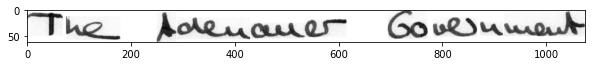

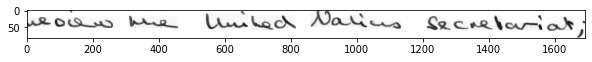

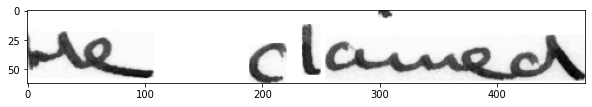

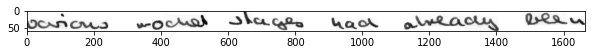

In [ ]:
sample_test=test_files[:]
import random
for i in range(5):
    random_file=random.choice(sample_test)
    
    target_file=[]
    images_rand_file=[]
    im = Image.open(random_file)
    cur_width = im.size[0]
    cur_height = im.size[1]
    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS) 
    now_width = imresize.size[0]
    now_height = imresize.size[1]
       

    avail_x_points = list(range(0, now_width - 113 ))

        
    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
        
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images_rand_file.append(np.asarray(imcrop))
        target_file.append(test_targets[51])
    X_test1 = np.array(images_rand_file)
    X_test1 = X_test1.reshape(X_test1.shape[0], 113, 113, 1)
    X_test1 = X_test1.astype('float32')
    X_test1 /= 255
    predictions1 = model.predict(X_test1, verbose =1)
    predicted_writer1 = []
    for pred in predictions1:
        predicted_writer1.append(np.argmax(pred))
    l6=[]
    if list(set(predicted_writer1))[0]==list(set(l4))[0]:
      l6.append(random_file)
    l5=[]
    if l6 !=[]:
      for i in select_forms:
        if select_forms[i]==top_7[list(set(predicted_writer1))[0]]:
          l5.append(i)
    else:
      print("wrong output")
    if l6!=[]:
       s1=random_file.split('/')[-2]
       d1={}
       with open('/content/drive/My Drive/TCS1/sentences.txt') as f:
          for line in f:
             key=line.split(' ')[0]
             write=line.split(' ')[9]
             d1[key]=write
       if s1 in l5:
             img=mpimg.imread(random_file)
             plt.figure(figsize=(10,10))
             plt.imshow(img,cmap='gray')
    
             final_pic=random_file.split('/')[-1].split('.')[0]
             print(d1[final_pic])
       
       
       
    

   
